# Objective

1. Dividing NYC to Zones


2. Constructing Road Network


3. Mapping Network to Zones


4. Designing a method for the shortest path

In [11]:
import pandas as pd

import folium

import geopandas as gp

import numpy as np



from scipy.spatial import ConvexHull

import random

from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt

import networkx as nx

import math

# from osgeo import ogr


In [12]:
'''1. Dividing NYC to Zones'''

Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data[['borough','zone','geometry']]

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry','center']]


'''Save the processed data'''

Zone_list=list()

Zone_Center={}

Taxi_Zones={}

for idx, row in Zone_data.iterrows():
    
    zone_id=row['Zone_id']
    
    center=list(row['center'].coords)[0]
    
    geometry=row['geometry']
    
    Zone_list.append(zone_id)
    
    Zone_Center[zone_id]=center
    
    Taxi_Zones[zone_id]=geometry
    
np.save('./Data/NYC_Zones/Zone_list',Zone_list)
    
np.save('./Data/NYC_Zones/Zone_Center',Zone_Center)

np.save('./Data/NYC_Zones/Taxi_Zones',Taxi_Zones)

Zone_data


,Zone_id,borough,zone,geometry,center
0,Zone_0,Manhattan,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",POINT (-73.97696825691759 40.72375214158459)
1,Zone_1,Manhattan,Bloomingdale,"POLYGON ((-73.95954 40.79872, -73.96004 40.798...",POINT (-73.96547951516966 40.80197049389943)
2,Zone_2,Manhattan,Battery Park,"POLYGON ((-74.01566 40.70483, -74.01540 40.704...",POINT (-74.01556351255894 40.70294583498452)
3,Zone_3,Manhattan,Battery Park City,"POLYGON ((-74.01244 40.71906, -74.01282 40.717...",POINT (-74.01607915192938 40.71203815707432)
4,Zone_4,Manhattan,Central Harlem,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",POINT (-73.95129200243512 40.80433394979442)
5,Zone_5,Manhattan,Chinatown,"POLYGON ((-73.99750 40.71407, -73.99744 40.714...",POINT (-73.99815149899052 40.71245931177932)
6,Zone_6,Manhattan,Central Harlem North,"POLYGON ((-73.93436 40.83620, -73.93445 40.835...",POINT (-73.94077166756259 40.81825786111904)
7,Zone_7,Manhattan,Central Park,"POLYGON ((-73.97255 40.76490, -73.97301 40.764...",POINT (-73.96555356545908 40.78247809974769)
8,Zone_8,Manhattan,Clinton East,"POLYGON ((-73.99118 40.75533, -73.99163 40.754...",POINT (-73.989844643133 40.76225275531919)
9,Zone_9,Manhattan,Clinton West,"POLYGON ((-73.99668 40.77351, -73.99434 40.772...",POINT (-73.9951352207551 40.76623772504166)


In [13]:
'''2. Constructing Road Network'''

Street_data = gp.read_file('./Data/NYC_Street/geo_export_2d0a9cb9-782e-42c0-ba15-7345a0f64002.shp')

Street_data=Street_data.loc[(Street_data['borocode']=='1')&(Street_data['rw_type']==1)&(Street_data['status']=='2')]

Street_data=Street_data[['st_name','geometry','shape_leng']]

Street_data=Street_data.reset_index(drop=True)

Street_data['Link_id']=['Link_'+str(i) for i in Street_data.index]

Street_data=Street_data[['Link_id','st_name','geometry','shape_leng']]

Street_data['start']=Street_data.apply(lambda x:Point(list(x['geometry'].coords)[0]),axis=1)

Street_data['end']=Street_data.apply(lambda x:Point(list(x['geometry'].coords)[-1]),axis=1)

Street_data['middle']=Street_data.apply(lambda x:Point(list(x['geometry'].coords)[math.ceil(len(list(x['geometry'].coords))/2.0)]),axis=1)

Street_data



,Link_id,st_name,geometry,shape_leng,start,end,middle
0,Link_0,BENNETT,"LINESTRING (-73.93666 40.85045, -73.93620 40.8...",735.721079,POINT (-73.93666142761384 40.85044732520501),POINT (-73.93571740885848 40.85233515231317),POINT (-73.93615190296994 40.85146696770021)
1,Link_1,STONE,"LINESTRING (-74.01007 40.70455, -74.00975 40.7...",122.538700,POINT (-74.01006968341342 40.70454591413196),POINT (-74.00974639311217 40.70477524791872),POINT (-74.00974639311217 40.70477524791872)
2,Link_2,GOLD,"LINESTRING (-74.00684 40.70786, -74.00653 40.7...",159.149459,POINT (-74.0068377870997 40.70785783573788),POINT (-74.00653116871753 40.70822712625459),POINT (-74.00653116871753 40.70822712625459)
3,Link_3,109,"LINESTRING (-73.94969 40.79622, -73.94919 40.7...",508.092565,POINT (-73.94968682996546 40.79621698487826),POINT (-73.94808516529754 40.79553641772942),POINT (-73.94904329476765 40.79594127353833)
4,Link_4,AMSTERDAM,"LINESTRING (-73.93192 40.84671, -73.93185 40.8...",38.069869,POINT (-73.93191507377053 40.8467105236121),POINT (-73.93185010295767 40.84680263276957),POINT (-73.93185010295767 40.84680263276957)
5,Link_5,EIGHTH,"LINESTRING (-73.99575 40.74905, -73.99530 40.7...",257.894368,POINT (-73.99574855573138 40.74905219622094),POINT (-73.99529821527037 40.74967168209748),POINT (-73.99529821527037 40.74967168209748)
6,Link_6,61,"LINESTRING (-73.96107 40.76086, -73.95881 40.7...",714.075356,POINT (-73.96106754453669 40.76085809262594),POINT (-73.95880955474563 40.75991278601397),POINT (-73.95880955474563 40.75991278601397)
7,Link_7,GREENWICH,"LINESTRING (-74.00680 40.73572, -74.00662 40.7...",262.936962,POINT (-74.00679907002781 40.73572292371414),POINT (-74.006620319663 40.73643169692291),POINT (-74.006620319663 40.73643169692291)
8,Link_8,3,"LINESTRING (-73.96111 40.76906, -73.96060 40.7...",286.455576,POINT (-73.96110997058013 40.76906440780265),POINT (-73.96060180637529 40.76974918670643),POINT (-73.96060180637529 40.76974918670643)
9,Link_9,HARLEM RIV,"LINESTRING (-73.93483 40.81406, -73.93469 40.8...",74.751585,POINT (-73.93483229160476 40.81405547181298),POINT (-73.93469166469954 40.81423063007637),POINT (-73.93469166469954 40.81423063007637)


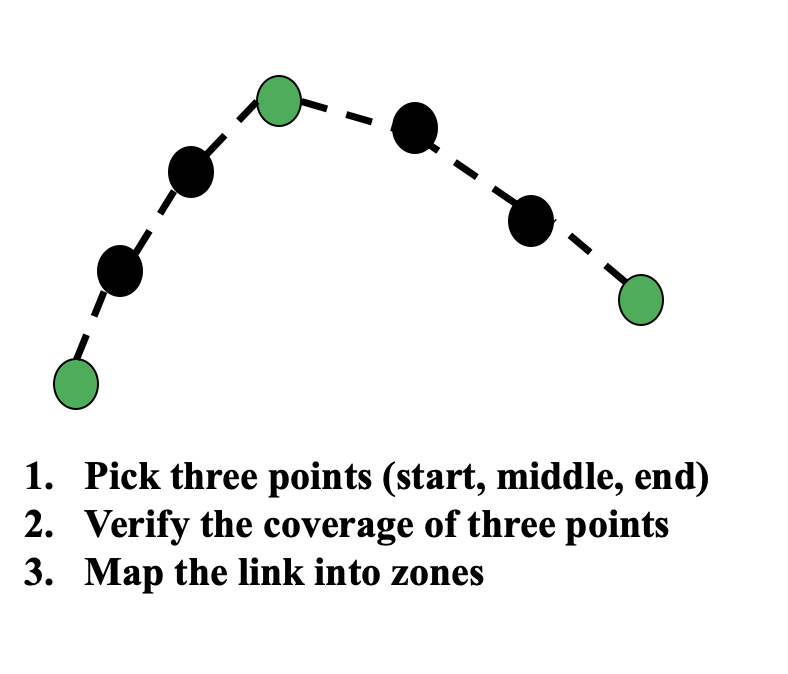

In [14]:
'''3. Mapping Network to Zones'''

def Check_point(pnt,polys):
    
    key='None'
    
    for key, geom in polys.items():
        
        if pnt.within(geom):
            
            break
            
    return key

def Get_zones(start,middle,end,polys):
    
    Zone_list=list()
    
    Zone_list.append(Check_point(start,polys))
    
    if Check_point(middle,polys) not in Zone_list:
        
        Zone_list.append(Check_point(middle,polys))
        
    if Check_point(end,polys) not in Zone_list:
        
        Zone_list.append(Check_point(end,polys))
        
    return Zone_list
  

polys = gp.GeoSeries(Taxi_Zones)

Street_data['Zones']=Street_data.apply(lambda x:Get_zones(x['start'],x['middle'],x['end'],polys),axis=1)

'''Save the processed data'''

Link_list=list()

Link_middle={}

Link_network={}

Link_length={}

Zone_Link={zone:[] for zone in Zone_list}

for idx,row in Street_data.iterrows():
    
    Link_list.append(row['Link_id'])
    
    Link_middle[row['Link_id']]=row['middle']
    
    Link_network[row['Link_id']]=row['geometry']
    
    Link_length[row['Link_id']]=row['shape_leng']
    
    for zone in row['Zones']:
        
        Zone_Link[zone].append(row['Link_id'])

np.save('./Data/NYC_Zones/Link_list',Link_list)
np.save('./Data/NYC_Zones/Link_middle',Link_middle)
np.save('./Data/NYC_Zones/Link_network',Link_network)
np.save('./Data/NYC_Zones/Link_length',Link_length)

np.save('./Data/NYC_Zones/Zone_Link',Zone_Link)



Street_data



,Link_id,st_name,geometry,shape_leng,start,end,middle,Zones
0,Link_0,BENNETT,"LINESTRING (-73.93666 40.85045, -73.93620 40.8...",735.721079,POINT (-73.93666142761384 40.85044732520501),POINT (-73.93571740885848 40.85233515231317),POINT (-73.93615190296994 40.85146696770021),"[Zone_64, Zone_63]"
1,Link_1,STONE,"LINESTRING (-74.01007 40.70455, -74.00975 40.7...",122.538700,POINT (-74.01006968341342 40.70454591413196),POINT (-74.00974639311217 40.70477524791872),POINT (-74.00974639311217 40.70477524791872),[Zone_15]
2,Link_2,GOLD,"LINESTRING (-74.00684 40.70786, -74.00653 40.7...",159.149459,POINT (-74.0068377870997 40.70785783573788),POINT (-74.00653116871753 40.70822712625459),POINT (-74.00653116871753 40.70822712625459),[Zone_14]
3,Link_3,109,"LINESTRING (-73.94969 40.79622, -73.94919 40.7...",508.092565,POINT (-73.94968682996546 40.79621698487826),POINT (-73.94808516529754 40.79553641772942),POINT (-73.94904329476765 40.79594127353833),[Zone_13]
4,Link_4,AMSTERDAM,"LINESTRING (-73.93192 40.84671, -73.93185 40.8...",38.069869,POINT (-73.93191507377053 40.8467105236121),POINT (-73.93185010295767 40.84680263276957),POINT (-73.93185010295767 40.84680263276957),[Zone_26]
5,Link_5,EIGHTH,"LINESTRING (-73.99575 40.74905, -73.99530 40.7...",257.894368,POINT (-73.99574855573138 40.74905219622094),POINT (-73.99529821527037 40.74967168209748),POINT (-73.99529821527037 40.74967168209748),"[Zone_10, Zone_46]"
6,Link_6,61,"LINESTRING (-73.96107 40.76086, -73.95881 40.7...",714.075356,POINT (-73.96106754453669 40.76085809262594),POINT (-73.95880955474563 40.75991278601397),POINT (-73.95880955474563 40.75991278601397),[Zone_30]
7,Link_7,GREENWICH,"LINESTRING (-74.00680 40.73572, -74.00662 40.7...",262.936962,POINT (-74.00679907002781 40.73572292371414),POINT (-74.006620319663 40.73643169692291),POINT (-74.006620319663 40.73643169692291),[Zone_39]
8,Link_8,3,"LINESTRING (-73.96111 40.76906, -73.96060 40.7...",286.455576,POINT (-73.96110997058013 40.76906440780265),POINT (-73.96060180637529 40.76974918670643),POINT (-73.96060180637529 40.76974918670643),[Zone_60]
9,Link_9,HARLEM RIV,"LINESTRING (-73.93483 40.81406, -73.93469 40.8...",74.751585,POINT (-73.93483229160476 40.81405547181298),POINT (-73.93469166469954 40.81423063007637),POINT (-73.93469166469954 40.81423063007637),[Zone_12]


In [15]:
'''Point Objects'''

Get_Str=lambda x,pos:str(list(x[pos].coords)[0][0])+'&'+str(list(x[pos].coords)[0][1])

Street_data['start_str']=Street_data.apply(lambda x:Get_Str(x,'start'),axis=1)

Street_data['end_str']=Street_data.apply(lambda x:Get_Str(x,'end'),axis=1)

Ponits_str=list(set(list(Street_data['start_str'])+list(Street_data['end_str'])))

Ponits_dic={Ponits_str[i]:'Point_'+str(i) for i in range(len(Ponits_str))}

Points_list=list(Ponits_dic.values())

Street_data['start_point']=Street_data.apply(lambda x:Ponits_dic[x['start_str']],axis=1)

Street_data['end_point']=Street_data.apply(lambda x:Ponits_dic[x['end_str']],axis=1)

'''Save the processed data'''

Link_Point={}

Points_link={}

Point_coordinate={}

for idx,row in Street_data.iterrows():
    
    Link_Point[row['Link_id']]=(row['start_point'],row['end_point'],row['shape_leng'])
    
    Points_link[row['start_point']+'&'+row['end_point']]=row['Link_id']
    
    Points_link[row['end_point']+'&'+row['start_point']]=row['Link_id']
    
    if row['start_point'] not in Point_coordinate.keys():
        Point_coordinate[row['start_point']]=row['start']
    if row['end_point'] not in Point_coordinate.keys():
        Point_coordinate[row['end_point']]=row['end']

np.save('./Data/NYC_Zones/Points_list',Points_list)

np.save('./Data/NYC_Zones/Link_Point',Link_Point)

np.save('./Data/NYC_Zones/Points_link',Points_link)

np.save('./Data/NYC_Zones/Point_coordinate',Point_coordinate)

'''Graph'''

G = nx.Graph()

G.add_nodes_from(Points_list)

G.add_weighted_edges_from(list(Link_Point.values()))



In [24]:
'''4. Designing a method for the shortest path'''

def Get_part(source,target):
    
    path=nx.shortest_path(G, source=source, target=target,weight='weight')
    
    shortest_dis=nx.shortest_path_length(G, source=source, target=target,weight='weight')
    
    link_path=list()
    
    
    for i in range(1,len(path),1):
        
        pnts=path[i-1]+"&"+path[i]
        
        link_path.append(Points_link[pnts])
        
    return link_path,shortest_dis
    

link_path,shortest_dis=Get_part('Point_6','Point_14')

shortest_dis


13345.152727039598

In [25]:
'''Visualization'''

'''Background'''

background = folium.Map([40.769602, -73.973667],tiles='openstreetmap',zoom_start=12)

'''Zones'''

folium.Choropleth(
    geo_data=Zone_data[['geometry']],
    fill_color='green',
    fill_opacity=0.1,
    name='Zone').add_to(background)

'''Street'''

for idx, row in Street_data.iterrows():
    
    folium.PolyLine([x[::-1] for x in list(row['geometry'].coords)],\
                    color="blue",\
                    weight=1.0,\
                    opacity=0.6).add_to(background)
    
'''Center of each zone'''

# for idx, row in Zone_data.iterrows():
#     folium.Circle(
#         radius=10,
#         location=list(row['center'].coords)[0][::-1],
#         popup='The Waterfront',
#         color='red',
#         fill=True,
#     ).add_to(background)

folium.LayerControl().add_to(background)

background.save('background.html')